In [18]:
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt

In [19]:
import torch
import torch.nn as nn

print(torch.cuda.is_available())

True


In [20]:
class SITE_TYPE(Enum):
  HOME = "HOME"
  POOR = "POOR"
  GOOD = "GOOD"

In [21]:
class ANT_STATE(Enum):
  ASSESSING_HOME_SITE = "ASSESSING_HOME_SITE"
  ASSESSING_POOR_SITE = "ASSESSING_POOR_SITE"
  ASSESSING_GOOD_SITE = "ASSESSING_GOOD_SITE"
  COMMITTED_TO_GOOD_SITE = "COMMITTED_TO_GOOD_SITE"
  COMMITTED_TO_POOR_SITE = "COMMITTED_TO_POOR_SITE"

In [22]:
class Site:
  def __init__(self, type, quality):
    self.type = type
    self.quality = quality

In [23]:
class Ant:
  def __init__(self, state, acceptance_threshold, a_nest=0, b_nest=0, assessment_error=None):
    self.state = state
    self.acceptance_threshold = acceptance_threshold
    self.assessment_error = assessment_error
    self.a_nest = a_nest
    self.b_nest = b_nest

In [24]:
def initialize_home_site():
  return Site(SITE_TYPE.HOME, float('-inf'))

In [25]:
def initialize_poor_site():
  return Site(SITE_TYPE.POOR, 4)

In [26]:
def initialize_good_site():
  return Site(SITE_TYPE.GOOD, 6)

In [27]:
def get_random_point(mean, std_deviation):
  return np.random.normal(loc=mean, scale=std_deviation)

In [28]:
def initialize_ant():
  return Ant(state = ANT_STATE.ASSESSING_HOME_SITE, acceptance_threshold=get_random_point(mean = 5, std_deviation= 1))

In [29]:
transition_matrix = np.array([
    [0.91, 0.06, 0.03],
    [0.15, 0.80, 0.05],
    [0.03, 0.06, 0.91]
])

In [30]:
def choose_next_site(current_site):
    current_index = {
        SITE_TYPE.HOME: 0,
        SITE_TYPE.POOR: 1,
        SITE_TYPE.GOOD: 2
    }[current_site.type]

    probabilities = transition_matrix[current_index]

    next_site_type = np.random.choice(
        [SITE_TYPE.HOME, SITE_TYPE.POOR, SITE_TYPE.GOOD],
        p=probabilities
    )
    if(next_site_type == SITE_TYPE.HOME):
      next_site = initialize_home_site()
    elif(next_site_type == SITE_TYPE.GOOD):
      next_site = initialize_good_site()
    else:
      next_site = initialize_poor_site()
    return next_site

In [31]:
def assess_site(ant, site):
  if (ant.state == ANT_STATE.COMMITTED_TO_GOOD_SITE or ant.state == ANT_STATE.COMMITTED_TO_POOR_SITE):
    return
  else:
    ant.assessment_error = get_random_point(0, 1)
    if site.quality > (ant.acceptance_threshold + ant.assessment_error):
      if site.type == SITE_TYPE.GOOD:
        ant.state = ANT_STATE.COMMITTED_TO_GOOD_SITE
      else:
        ant.state = ANT_STATE.COMMITTED_TO_POOR_SITE
    else:
      return

In [32]:
def simulate_single_ant(ant, site):
  assess_site(ant, site)
  if (ant.state == ANT_STATE.COMMITTED_TO_GOOD_SITE or ant.state == ANT_STATE.COMMITTED_TO_POOR_SITE):
    return ant
  else:
    new_site = choose_next_site(site)
    if new_site.type == SITE_TYPE.GOOD:
      ant.a_nest = 1
      ant.state = ANT_STATE.ASSESSING_GOOD_SITE
    elif new_site.type == SITE_TYPE.POOR:
      ant.b_nest = 1
      ant.state = ANT_STATE.ASSESSING_POOR_SITE
    simulate_single_ant(ant, new_site)

In [33]:
def simulate():
  new_ant = initialize_ant()
  home_site = initialize_home_site()
  simulate_single_ant(new_ant, home_site)
  if new_ant.state == ANT_STATE.COMMITTED_TO_POOR_SITE:
    return (ANT_STATE.COMMITTED_TO_POOR_SITE, new_ant.a_nest, new_ant.b_nest)
  else:
     return (ANT_STATE.COMMITTED_TO_GOOD_SITE, new_ant.a_nest, new_ant.b_nest)

In [34]:
good_site_ants = [0, 0]
poor_site_ants = [0, 0]
n = 27
for i in range(n):
  status, a_status, b_status = simulate()
  if status == ANT_STATE.COMMITTED_TO_GOOD_SITE:
    good_site_ants[0] += 1
    good_site_ants[1] += b_status
  else:
    poor_site_ants[0] += 1
    poor_site_ants[1] += a_status

print("From " + str(n) + " ants, " + str(good_site_ants[0]) + " ants committed to the good site and " + str(good_site_ants[1]) + " came from bad site first.")
print("From " + str(n) + " ants, " + str(poor_site_ants[0]) + " ants committed to the poor site and " + str(poor_site_ants[1]) + " came from good site first.")

From 27 ants, 12 ants committed to the good site and 7 came from bad site first.
From 27 ants, 15 ants committed to the poor site and 0 came from good site first.


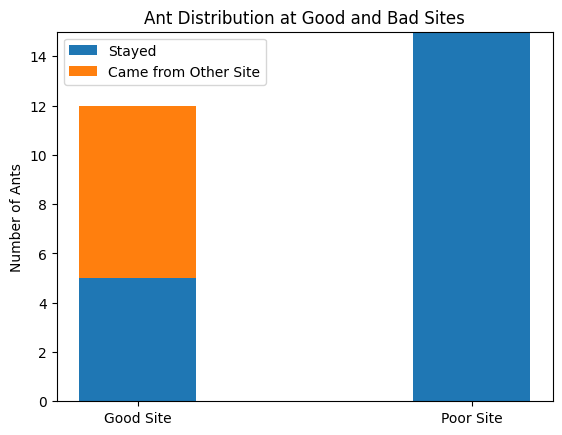

In [38]:
# Plotting results.

good_site = [good_site_ants[0] - good_site_ants[1], good_site_ants[1]]
bad_site = [poor_site_ants[0] - poor_site_ants[1], poor_site_ants[1]]

labels = ['Good Site', 'Poor Site']
x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x, [good_site[0], bad_site[0]], width, label='Stayed')
ax.bar(x, [good_site[1], bad_site[1]], width, bottom=[good_site[0], bad_site[0]], label='Came from Other Site')

ax.set_ylabel('Number of Ants')
ax.set_title('Ant Distribution at Good and Bad Sites')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()
